In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Bidirectional, LSTM, LeakyReLU, Conv1D

In [85]:
LABEL_DIR = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\train_labels\\"
AUDIO_DIR = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\train_data\\"

In [86]:
LABEL_DIR_TEST = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\test_labels\\"
AUDIO_DIR_TEST = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\test_data\\"

In [87]:
audio_file = pd.DataFrame(columns = ['audio', 'instrument'])

In [88]:
for i in os.listdir(LABEL_DIR):
    
    audio_csv = pd.read_csv("{}\\{}".format(LABEL_DIR, i))
    
    audio_file = audio_file.append({'audio':i,
                          'instrument':",".join(audio_csv['instrument'].unique().astype(str))}, ignore_index = True)

In [89]:
audio_file.head()

,audio,instrument
0,1727.csv,"43,42,1,44,41"
1,1728.csv,"42,41,43,1,44"
2,1729.csv,"41,42,43,44,1"
3,1730.csv,"43,42,1,44,41"
4,1733.csv,1


In [90]:
instruments = audio_file['instrument'].str.get_dummies(sep=',')
instruments.head()

,1,41,42,43,44,61,69,7,71,72,74
0,1,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [91]:
audio_file_test = pd.DataFrame(columns = ['audio', 'instrument'])

In [92]:
for i in os.listdir(LABEL_DIR_TEST):
    
    audio_csv = pd.read_csv("{}\\{}".format(LABEL_DIR_TEST, i))
    
    audio_file_test = audio_file_test.append({'audio':i,
                          'instrument':",".join(audio_csv['instrument'].unique().astype(str))}, ignore_index = True)

In [93]:
instruments_test = audio_file_test['instrument'].str.get_dummies(sep=',')
instruments_test.head()

,1,41,42,43,61,71,72
0,1,0,0,0,0,0,0
1,0,0,0,0,1,1,1
2,0,1,1,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0


In [94]:
instruments_test['44'] = pd.Series([0]*10, index=instruments_test.index)
instruments_test['69'] = pd.Series([0]*10, index=instruments_test.index)
instruments_test['7'] = pd.Series([0]*10, index=instruments_test.index)
instruments_test['74'] = pd.Series([0]*10, index=instruments_test.index)

In [96]:
instruments_test = instruments_test[['1','41','42','43','44','61','69','7','71','72','74']]
instruments_test.head()

,1,41,42,43,44,61,69,7,71,72,74
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,1,0
2,0,1,1,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [67]:
n_instruments = 11

In [68]:
sr = 44100
duration = 5
samples = sr * duration

In [69]:
#Reads in the audio file and returns an array that we can turn into a melspectogram

def read_audio(path):
    y, _ = librosa.core.load(path, sr=44100)
    
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

In [73]:
#Convert audio to melspectrogram

def audio_to_melspectrogram(audio):
    
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sr)
    
    return librosa.power_to_db(spectrogram).astype(np.float32)

def read_as_melspectrogram(path):
    
    mels = audio_to_melspectrogram(read_audio(path))
    return mels

In [74]:
def convert_wav_to_image(df, path):
    X = []
    for _, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram('{}{}.wav'.format(path, str(row['audio']).split('.')[0]))
        X.append(x.transpose())
    
    return X

def normalize(img):
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

In [72]:
X = np.array(convert_wav_to_image(audio_file, AUDIO_DIR))

<ipython-input-71-50a4e01e156a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm_notebook(df.iterrows()):


In [75]:
X = normalize_dataset(X)

In [76]:
Y = instruments.values

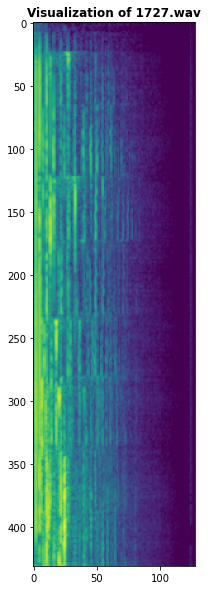

In [77]:
# Visualize an melspectogram example

plt.figure(figsize=(15,10))
plt.title('Visualization of 1727.wav', weight='bold')
plt.imshow(X[0])
plt.show()

In [78]:
X_test = np.array(convert_wav_to_image(audio_file_test, AUDIO_DIR_TEST))

<ipython-input-74-50a4e01e156a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm_notebook(df.iterrows()):


In [79]:
X_test = normalize_dataset(X_test)

In [97]:
Y_test = instruments_test.values

In [26]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [102]:
# LSTM Model
input_shape = (431,128)
n_classes = 80

model = Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
model.add(Attention(431))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2)) 
model.add(Dense(n_instruments, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])

In [103]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 431, 128)          98816     
_________________________________________________________________
attention_4 (Attention)      (None, 128)               559       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 11)                187       
Total params: 101,626
Trainable params: 101,626
Non-trainable params: 0
________________________________________________

In [104]:
# Training model
history = model.fit(np.array(X), Y, epochs=250)

Epoch 1/250
10/10 [==============================] - 2s 34ms/step - loss: 4.5154 - acc: 0.3684
Epoch 2/250
10/10 [==============================] - 0s 29ms/step - loss: 4.8299 - acc: 0.6187
Epoch 3/250
10/10 [==============================] - 0s 29ms/step - loss: 5.7370 - acc: 0.5289
Epoch 4/250
10/10 [==============================] - 0s 29ms/step - loss: 5.8421 - acc: 0.5278
Epoch 5/250
10/10 [==============================] - 0s 29ms/step - loss: 7.7786 - acc: 0.4407
Epoch 6/250
10/10 [==============================] - 0s 29ms/step - loss: 10.0604 - acc: 0.4680
Epoch 7/250
10/10 [==============================] - 0s 29ms/step - loss: 10.2562 - acc: 0.5248
Epoch 8/250
10/10 [==============================] - 0s 29ms/step - loss: 12.6089 - acc: 0.4055
Epoch 9/250
10/10 [==============================] - 0s 29ms/step - loss: 14.8156 - acc: 0.5190
Epoch 10/250
10/10 [==============================] - 0s 29ms/step - loss: 17.5317 - acc: 0.4096
Epoch 11/250
10/10 [========================

10/10 [==============================] - 0s 31ms/step - loss: 538.3136 - acc: 0.3387
Epoch 168/250
10/10 [==============================] - 0s 31ms/step - loss: 425.5411 - acc: 0.3564
Epoch 169/250
10/10 [==============================] - 0s 30ms/step - loss: 375.0263 - acc: 0.3071
Epoch 170/250
10/10 [==============================] - 0s 30ms/step - loss: 360.0115 - acc: 0.3996
Epoch 171/250
10/10 [==============================] - 0s 29ms/step - loss: 419.1069 - acc: 0.3726
Epoch 172/250
10/10 [==============================] - 0s 31ms/step - loss: 449.6512 - acc: 0.3960
Epoch 173/250
10/10 [==============================] - 0s 31ms/step - loss: 364.1066 - acc: 0.4641
Epoch 174/250
10/10 [==============================] - 0s 31ms/step - loss: 433.3058 - acc: 0.3660
Epoch 175/250
10/10 [==============================] - 0s 29ms/step - loss: 481.3920 - acc: 0.3154
Epoch 176/250
10/10 [==============================] - 0s 31ms/step - loss: 559.9477 - acc: 0.4059
Epoch 177/250
10/10 [===

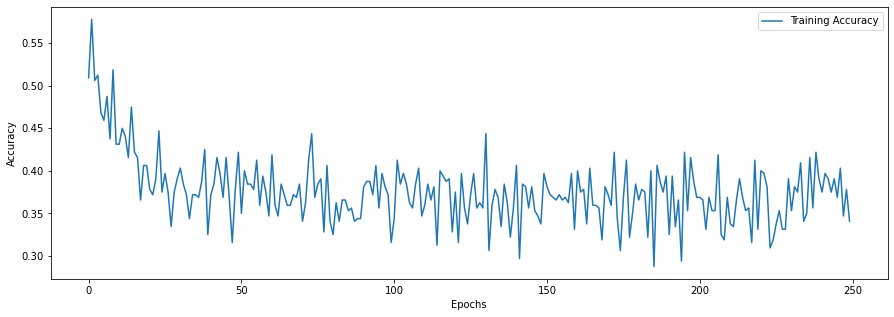

In [105]:
# Accuracy Visualization
epochs = range(250)

plt.figure(figsize=(15,5))
plt.plot(epochs, history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy'])
plt.show()